In [1]:
# import jupyter_black

# jupyter_black.load()

In [90]:
%autosave 300
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [91]:
import os

os.chdir(
    r"/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/abi_hackathon_2k24"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/abi_hackathon_2k24


In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", None)
from pandarallel import pandarallel
import re
from datetime import datetime
import gc
from sklearn.preprocessing import FunctionTransformer

# from helpers.compress import reduce_mem_usage
import pickle
import warnings

warnings.filterwarnings("ignore")

In [93]:
data_folder = "data"
macro_data_folder = "macro_data"
processed_data_folder = "processed_data_S2"
processed_macro = "macro_processed"
fe_data = "feature_engineered_data"

- volumne monthly, sample_submission, id_lifedata
- add a marker for identified ones in id life
- take the top 3 combinations by rank
- start creating features from target

In [94]:
volume_monthly_df = pd.read_pickle(
    os.path.join(os.getcwd(), processed_data_folder, "volume_df_month_agg.pkl")
)
sample_submission_df = pd.read_csv(
    os.path.join(os.getcwd(), data_folder, "sample_submission_file.csv")
)
id_life_df = pd.read_pickle(
    os.path.join(os.getcwd(), processed_data_folder, "id_date_life.pkl")
)

##### sampling some sample ids from the submission file

In [95]:
sample_submission_df.head()

,year,quarter,ppg_name,unique_poc_id,quarterly_sales_hl
0,2023,1,CJ C FN M,BATE,NaN
1,2023,1,GH CI CQ ES AX,AKMJ,NaN
2,2023,1,GH CI CQ FN DX,CEH,NaN
3,2023,1,CJ C FN M,BKED,NaN
4,2023,1,CJ C FN M,RAP,NaN


In [96]:
best_poc = sample_submission_df["unique_poc_id"].unique().tolist()
best_ppg = sample_submission_df["ppg_name"].unique().tolist()

In [97]:
len(best_poc), len(best_ppg)

(21387, 25)

In [98]:
id_life_df_best = id_life_df.loc[
    (id_life_df["unique_poc_id"].isin(best_poc))
    & (id_life_df["ppg_name"].isin(best_ppg))
].reset_index(drop=True)

In [99]:
id_life_df_best.shape[0] / id_life_df.shape[0]

0.14357748587107635

In [100]:
# id_life_df.loc[id_life_df['unique_poc_id']=='ALFP']

In [101]:
missed_poc = list(
    set(best_poc).difference(set(id_life_df_best["unique_poc_id"].unique()))
)
len(missed_poc)

1077

In [102]:
missed_ppg = list(set(best_ppg).difference(set(id_life_df_best["ppg_name"].unique())))
len(missed_ppg)

5

In [103]:
sample_submission_df.head()

,year,quarter,ppg_name,unique_poc_id,quarterly_sales_hl
0,2023,1,CJ C FN M,BATE,NaN
1,2023,1,GH CI CQ ES AX,AKMJ,NaN
2,2023,1,GH CI CQ FN DX,CEH,NaN
3,2023,1,CJ C FN M,BKED,NaN
4,2023,1,CJ C FN M,RAP,NaN


In [104]:
# clean name
sample_submission_df["ppg_name_clean"] = sample_submission_df["ppg_name"].apply(
    lambda x: re.sub(r"\s+", "_", x)
)
# poc-Ppg id
sample_submission_df["poc_ppg_id"] = sample_submission_df.apply(
    lambda x: str(x["unique_poc_id"]) + "__" + str(x["ppg_name_clean"]), axis=1
)

In [105]:
best_ids = sample_submission_df["poc_ppg_id"].unique().tolist()
print(len(best_ids))

49337


In [106]:
# volume_df = pd.read_pickle(
#     os.path.join(os.getcwd(), processed_data_folder, "volume_clean_daily.pkl")
# )

In [107]:
# volume_df.loc[volume_df["unique_poc_id"] == missed_poc[10]].head()

In [108]:
volume_monthly_df.shape

(79049668, 7)

In [109]:
volume_monthly_df.head()

,poc_ppg_id,ppg_name,unique_poc_id,year,month,sales_volume_hl_agg,year_month_start_date
0,AAAA__AK_AB_CG_T,AK AB CG T,AAAA,2019,4,0.065803,2019-04-01
1,AAAA__AK_AB_CG_T,AK AB CG T,AAAA,2019,5,0.131605,2019-05-01
2,AAAA__AK_CW_FM_CG_T,AK CW FM CG T,AAAA,2020,6,0.098704,2020-06-01
3,AAAA__AR_EW_N_DS_CG_T,AR EW N DS CG T,AAAA,2019,2,0.164507,2019-02-01
4,AAAA__AR_EW_N_DS_CG_T,AR EW N DS CG T,AAAA,2019,4,0.098704,2019-04-01


In [110]:
volume_monthly_df_best = volume_monthly_df.loc[
    volume_monthly_df["poc_ppg_id"].isin(best_ids)
].reset_index(drop=True)

In [111]:
volume_monthly_df_best.shape[0] / volume_monthly_df.shape[0]

0.028017347270832306

In [112]:
volume_monthly_df_best.shape

(2214762, 7)

In [113]:
temp1 = volume_monthly_df_best.groupby(["poc_ppg_id", "month"], as_index=False).agg(
    {"sales_volume_hl_agg": "sum"}
)

In [114]:
temp1["mon_rank"] = temp1.groupby(["month"])["sales_volume_hl_agg"].transform(
    lambda x: x.rank(method="dense", ascending=False)
)

In [115]:
temp1.loc[temp1["month"] == 1].sort_values("mon_rank").head()

,poc_ppg_id,month,sales_volume_hl_agg,mon_rank
119724,AOEM__CJ_CZ_CG_EH,1,3631.742877,1.0
296592,BJFR__DG_CF_AF_CG_EH,1,3272.221381,2.0
149376,ARSH__DG_CF_AF_CG_EH,1,2884.546840,3.0
167136,AUAT__DG_CF_AF_CG_EH,1,2729.162966,4.0
369504,HWB__DG_CF_AF_CG_EH,1,2451.072192,5.0


In [116]:
temp1_pvt = pd.pivot_table(
    data=temp1, index="poc_ppg_id", columns="month", values="mon_rank", aggfunc="first"
)

In [117]:
temp1_pvt.columns = temp1_pvt.columns.get_level_values(-1)
temp1_pvt.columns.name = ""

In [118]:
temp1_pvt = temp1_pvt.reset_index(drop=False)

In [119]:
temp1_pvt["median_rank"] = temp1_pvt.loc[:, 1:12].median(axis=1)

In [120]:
temp1_pvt = temp1_pvt.sort_values(["median_rank"]).reset_index(drop=True)

In [121]:
temp1_pvt.shape

(43485, 14)

In [122]:
# temp1.loc[temp1['poc_ppg_id']=='BJFR__DG_CF_AF_CG_EH']

In [123]:
sample_ids = temp1_pvt.loc[:, "poc_ppg_id"].tolist()
print(len(sample_ids))

43485


In [124]:
volume_monthly_df_best = volume_monthly_df_best.loc[
    volume_monthly_df_best["poc_ppg_id"].isin(sample_ids)
].reset_index(drop=True)

In [125]:
volume_monthly_df_best = volume_monthly_df_best.sort_values(
    ["poc_ppg_id", "year", "month"]
).reset_index(drop=True)

In [126]:
volume_monthly_df_best.groupby(["poc_ppg_id", "year"])["month"].count().min()

1

##### next we setup framework to create features form target

Features
* lag 12 13...
* lag differences
* lagged rolling mean 3 months 6 months,9mons
* lagged weighted mean
* Category level seasonal indices
* Region Level indices
* seasonal features

Now is the time to bring cat features to calculate seasonality

In [127]:
poc_atrb_df = pd.read_pickle(
    os.path.join(os.getcwd(), processed_macro, "poc_atrb_df.pkl")
)
ppg_atrb_df = pd.read_pickle(
    os.path.join(os.getcwd(), processed_macro, "ppg_atrb_df.pkl")
)

In [128]:
poc_atrb_df.head()

,unique_poc_id,region,subchannel,channel_type,sales_district,segment
0,A,ALKP,AFMJ ZQQ,KVF,TGG BIRO AFDC ADCB,AHJB ZQQ
1,AA,ALKP,AFMJ ZQQ,KVF,TGG BIRO JIE,AHJB ZQQ
2,AAA,ALKP,FUK AIMO BGGD AGHI,BBOB,TGG BIRO ABNS,AKWM
3,AAAA,ALKP,ADDS ZQQ,KVF,TGG BIRO ABEP,AHJB ZQQ
4,AAAC,AZAK AHZ,AQXZ APPZ ADOT,BBOB,VOP BIRO ABXN,AZJC UIP


In [129]:
ppg_atrb_df.head()

,ppg_name,brand,subbrand,pack_type,pack_volume,category_name,price_segment
0,BN EQ BL FP FN D,BN EQ,BN EQ BL FP,FN,D,FT BM,FG
1,FA FN DY,FA,FA,FN,DY,BM,CW
2,DE AI BH ES DX,FD CL CO,DE AI BH,ES,DX,BM,EJ CW
3,CM ES T,CM,CM,ES,T,BM,CW
4,AK BK CG T,AK,AK BK,CG,T,FT BM,BR


In [130]:
volume_monthly_df_best.head()

,poc_ppg_id,ppg_name,unique_poc_id,year,month,sales_volume_hl_agg,year_month_start_date
0,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,9,2.657029,2021-09-01
1,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,10,1.635095,2021-10-01
2,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,11,5.477568,2021-11-01
3,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,12,4.905285,2021-12-01
4,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2022,1,0.613161,2022-01-01


In [131]:
# adding PPG details
volume_monthly_df_best = pd.merge(
    volume_monthly_df_best,
    ppg_atrb_df[["ppg_name", "category_name", "price_segment", "brand", "subbrand"]],
    on=["ppg_name"],
    how="left",
)

In [132]:
volume_monthly_df_best.isnull().sum()

poc_ppg_id               0
ppg_name                 0
unique_poc_id            0
year                     0
month                    0
sales_volume_hl_agg      0
year_month_start_date    0
category_name            0
price_segment            0
brand                    0
subbrand                 0
dtype: int64

In [133]:
# adding poc details
volume_monthly_df_best = pd.merge(
    volume_monthly_df_best,
    poc_atrb_df[["unique_poc_id", "subchannel", "channel_type", "segment"]],
    on=["unique_poc_id"],
    how="left",
)

In [134]:
volume_monthly_df_best.isnull().sum()

poc_ppg_id               0
ppg_name                 0
unique_poc_id            0
year                     0
month                    0
sales_volume_hl_agg      0
year_month_start_date    0
category_name            0
price_segment            0
brand                    0
subbrand                 0
subchannel               0
channel_type             0
segment                  0
dtype: int64

In [135]:
volume_monthly_df_best.head()

,poc_ppg_id,ppg_name,unique_poc_id,year,month,sales_volume_hl_agg,year_month_start_date,category_name,price_segment,brand,subbrand,subchannel,channel_type,segment
0,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,9,2.657029,2021-09-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP
1,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,10,1.635095,2021-10-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP
2,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,11,5.477568,2021-11-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP
3,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,12,4.905285,2021-12-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP
4,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2022,1,0.613161,2022-01-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP


###### Seasonal Indexes

In [136]:
volume_monthly_df_best["ppg_seasonality_index"] = volume_monthly_df_best.groupby(
    ["category_name", "price_segment", "month"]
)["sales_volume_hl_agg"].transform(lambda x: x.sum()) / volume_monthly_df_best.groupby(
    ["category_name", "price_segment"]
)[
    "sales_volume_hl_agg"
].transform(
    lambda x: x.sum()
)

In [137]:
volume_monthly_df_best.head()

,poc_ppg_id,ppg_name,unique_poc_id,year,month,sales_volume_hl_agg,year_month_start_date,category_name,price_segment,brand,subbrand,subchannel,channel_type,segment,ppg_seasonality_index
0,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,9,2.657029,2021-09-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP,0.088297
1,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,10,1.635095,2021-10-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP,0.112842
2,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,11,5.477568,2021-11-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP,0.162273
3,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,12,4.905285,2021-12-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP,0.175460
4,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2022,1,0.613161,2022-01-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP,0.025854


In [138]:
volume_monthly_df_best["poc_seasonality_index"] = volume_monthly_df_best.groupby(
    ["segment", "month"]
)["sales_volume_hl_agg"].transform(lambda x: x.sum()) / volume_monthly_df_best.groupby(
    ["segment"]
)[
    "sales_volume_hl_agg"
].transform(
    lambda x: x.sum()
)

In [139]:
volume_monthly_df_best.shape

(2214762, 16)

In [140]:
volume_monthly_df_best.isnull().sum()

poc_ppg_id               0
ppg_name                 0
unique_poc_id            0
year                     0
month                    0
sales_volume_hl_agg      0
year_month_start_date    0
category_name            0
price_segment            0
brand                    0
subbrand                 0
subchannel               0
channel_type             0
segment                  0
ppg_seasonality_index    0
poc_seasonality_index    0
dtype: int64

In [141]:
def random_noise(dataframe):
    return np.random.normal(scale=0.01, size=(len(dataframe)))

#### lag features

In [142]:
def lag_features(dataframe, lags, id_col, target_col):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe["sales_lag_" + str(lag)] = dataframe.groupby([id_col])[
            target_col
        ].transform(
            lambda x: x.shift(lag)
            .fillna(method="bfill")
            .fillna(method="ffill")
            .fillna(0.0)
        ) + random_noise(
            dataframe
        )
    return dataframe

In [143]:
feat1_df = lag_features(
    volume_monthly_df_best, [12, 13, 14], "poc_ppg_id", "sales_volume_hl_agg"
)

In [144]:
# feat1_df.loc[feat1_df["poc_ppg_id"] == sample_ids[1]]

In [145]:
feat1_df.isnull().sum()

poc_ppg_id               0
ppg_name                 0
unique_poc_id            0
year                     0
month                    0
sales_volume_hl_agg      0
year_month_start_date    0
category_name            0
price_segment            0
brand                    0
subbrand                 0
subchannel               0
channel_type             0
segment                  0
ppg_seasonality_index    0
poc_seasonality_index    0
sales_lag_12             0
sales_lag_13             0
sales_lag_14             0
dtype: int64

In [146]:
# feat1_df.loc[feat1_df["sales_lag_16"].isnull()]

#### lag diff

In [147]:
def calculate_lag_diff(dataframe):
    dataframe = dataframe.copy()
    diff_df = dataframe.filter(regex="sales_lag").diff(axis=1).dropna(axis=1, how="all")
    diff_df.columns = [col + "_diff" for col in diff_df.columns]
    dataframe = pd.concat([dataframe, diff_df], axis=1)
    return dataframe

In [148]:
feat1_df = calculate_lag_diff(feat1_df)

In [149]:
feat1_df.loc[feat1_df["poc_ppg_id"] == sample_ids[1]].head()

,poc_ppg_id,ppg_name,unique_poc_id,year,month,sales_volume_hl_agg,year_month_start_date,category_name,price_segment,brand,subbrand,subchannel,channel_type,segment,ppg_seasonality_index,poc_seasonality_index,sales_lag_12,sales_lag_13,sales_lag_14,sales_lag_13_diff,sales_lag_14_diff
219952,AGEA__DG_CF_AF_CG_EH,DG CF AF CG EH,AGEA,2019,1,80.608189,2019-01-01,BM,BR,DG CF AF,DG CF AF,FUK AZJC UIP,BBOB,AKWM,0.054764,0.053558,80.629316,80.617413,80.627478,-0.011902,0.010065
219953,AGEA__DG_CF_AF_CG_EH,DG CF AF CG EH,AGEA,2019,2,0.000000,2019-02-01,BM,BR,DG CF AF,DG CF AF,FUK AZJC UIP,BBOB,AKWM,0.083779,0.083193,80.615791,80.631126,80.622513,0.015335,-0.008613
219954,AGEA__DG_CF_AF_CG_EH,DG CF AF CG EH,AGEA,2019,3,1001.844633,2019-03-01,BM,BR,DG CF AF,DG CF AF,FUK AZJC UIP,BBOB,AKWM,0.085713,0.085717,80.632331,80.605286,80.601465,-0.027045,-0.003820
219955,AGEA__DG_CF_AF_CG_EH,DG CF AF CG EH,AGEA,2019,4,0.000000,2019-04-01,BM,BR,DG CF AF,DG CF AF,FUK AZJC UIP,BBOB,AKWM,0.065163,0.063866,80.595268,80.609699,80.597993,0.014431,-0.011706
219956,AGEA__DG_CF_AF_CG_EH,DG CF AF CG EH,AGEA,2019,5,0.000000,2019-05-01,BM,BR,DG CF AF,DG CF AF,FUK AZJC UIP,BBOB,AKWM,0.065413,0.064647,80.609411,80.604573,80.594802,-0.004837,-0.009772


In [150]:
feat1_df.isnull().sum()

poc_ppg_id               0
ppg_name                 0
unique_poc_id            0
year                     0
month                    0
sales_volume_hl_agg      0
year_month_start_date    0
category_name            0
price_segment            0
brand                    0
subbrand                 0
subchannel               0
channel_type             0
segment                  0
ppg_seasonality_index    0
poc_seasonality_index    0
sales_lag_12             0
sales_lag_13             0
sales_lag_14             0
sales_lag_13_diff        0
sales_lag_14_diff        0
dtype: int64

#### rolling mean

In [151]:
def roll_mean_features(dataframe, windows, id_col, target_col):
    dataframe = dataframe.copy()
    for window in windows:
        dataframe["sales_roll_mean_" + str(window)] = dataframe.groupby([id_col])[
            target_col
        ].transform(
            lambda x: x.shift(12)
            .rolling(window=window, min_periods=1)
            .mean()
            .fillna(method="bfill")
            .fillna(method="ffill")
            .fillna(0.0)
        ) + random_noise(
            dataframe
        )
    return dataframe

In [152]:
feat1_df = roll_mean_features(feat1_df, [3, 6, 9], "poc_ppg_id", "sales_volume_hl_agg")

In [153]:
feat1_df.loc[feat1_df["poc_ppg_id"] == sample_ids[0]].head()

,poc_ppg_id,ppg_name,unique_poc_id,year,month,sales_volume_hl_agg,year_month_start_date,category_name,price_segment,brand,subbrand,subchannel,channel_type,segment,ppg_seasonality_index,poc_seasonality_index,sales_lag_12,sales_lag_13,sales_lag_14,sales_lag_13_diff,sales_lag_14_diff,sales_roll_mean_3,sales_roll_mean_6,sales_roll_mean_9
1259017,BJFR__DG_CF_AF_CG_EH,DG CF AF CG EH,BJFR,2019,1,69.092733,2019-01-01,BM,BR,DG CF AF,DG CF AF,FUK AZJC UIP,BBOB,AKWM,0.054764,0.053558,69.106725,69.093426,69.090119,-0.013298,-0.003308,69.105888,69.098381,69.081843
1259018,BJFR__DG_CF_AF_CG_EH,DG CF AF CG EH,BJFR,2019,2,261.976614,2019-02-01,BM,BR,DG CF AF,DG CF AF,FUK AZJC UIP,BBOB,AKWM,0.083779,0.083193,69.087303,69.090140,69.097737,0.002837,0.007596,69.082088,69.089202,69.112557
1259019,BJFR__DG_CF_AF_CG_EH,DG CF AF CG EH,BJFR,2019,3,414.556400,2019-03-01,BM,BR,DG CF AF,DG CF AF,FUK AZJC UIP,BBOB,AKWM,0.085713,0.085717,69.101722,69.095991,69.100569,-0.005731,0.004578,69.075757,69.098900,69.093248
1259020,BJFR__DG_CF_AF_CG_EH,DG CF AF CG EH,BJFR,2019,4,208.960653,2019-04-01,BM,BR,DG CF AF,DG CF AF,FUK AZJC UIP,BBOB,AKWM,0.065163,0.063866,69.080752,69.089063,69.081690,0.008311,-0.007372,69.083489,69.086061,69.084093
1259021,BJFR__DG_CF_AF_CG_EH,DG CF AF CG EH,BJFR,2019,5,276.370933,2019-05-01,BM,BR,DG CF AF,DG CF AF,FUK AZJC UIP,BBOB,AKWM,0.065413,0.064647,69.097497,69.086768,69.087515,-0.010729,0.000747,69.096351,69.081941,69.083917


In [154]:
feat1_df.isnull().sum()

poc_ppg_id               0
ppg_name                 0
unique_poc_id            0
year                     0
month                    0
sales_volume_hl_agg      0
year_month_start_date    0
category_name            0
price_segment            0
brand                    0
subbrand                 0
subchannel               0
channel_type             0
segment                  0
ppg_seasonality_index    0
poc_seasonality_index    0
sales_lag_12             0
sales_lag_13             0
sales_lag_14             0
sales_lag_13_diff        0
sales_lag_14_diff        0
sales_roll_mean_3        0
sales_roll_mean_6        0
sales_roll_mean_9        0
dtype: int64

#### ewm

In [155]:
def ewm_features(dataframe, alphas, lags, id_col, target_col):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe[
                "sales_ewm_alpha_" + str(alpha).replace(".", "") + "_lag_" + str(lag)
            ] = dataframe.groupby([id_col])[target_col].transform(
                lambda x: x.shift(lag)
                .ewm(alpha=alpha, min_periods=1)
                .mean()
                .fillna(method="bfill")
                .fillna(method="ffill")
                .fillna(0.0)
            )
    return dataframe

In [156]:
feat1_df = ewm_features(
    feat1_df, [0.95, 0.9], [12, 13, 14], "poc_ppg_id", "sales_volume_hl_agg"
)

In [157]:
feat1_df.head()

,poc_ppg_id,ppg_name,unique_poc_id,year,month,sales_volume_hl_agg,year_month_start_date,category_name,price_segment,brand,subbrand,subchannel,channel_type,segment,ppg_seasonality_index,poc_seasonality_index,sales_lag_12,sales_lag_13,sales_lag_14,sales_lag_13_diff,sales_lag_14_diff,sales_roll_mean_3,sales_roll_mean_6,sales_roll_mean_9,sales_ewm_alpha_095_lag_12,sales_ewm_alpha_095_lag_13,sales_ewm_alpha_095_lag_14,sales_ewm_alpha_09_lag_12,sales_ewm_alpha_09_lag_13,sales_ewm_alpha_09_lag_14
0,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,9,2.657029,2021-09-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP,0.088297,0.084034,2.663596,2.647419,2.651171,-0.016176,0.003751,2.661960,2.663133,2.661383,2.657029,2.657029,2.657029,2.657029,2.657029,2.657029
1,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,10,1.635095,2021-10-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP,0.112842,0.105547,2.659938,2.641437,2.647701,-0.018501,0.006264,2.672616,2.667428,2.674300,2.657029,2.657029,2.657029,2.657029,2.657029,2.657029
2,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,11,5.477568,2021-11-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP,0.162273,0.120720,2.650589,2.655629,2.634622,0.005040,-0.021007,2.644605,2.654301,2.666382,2.657029,2.657029,2.657029,2.657029,2.657029,2.657029
3,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,12,4.905285,2021-12-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP,0.175460,0.134131,2.655569,2.651313,2.650865,-0.004256,-0.000448,2.647372,2.660954,2.670991,2.657029,2.657029,2.657029,2.657029,2.657029,2.657029
4,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2022,1,0.613161,2022-01-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP,0.025854,0.049269,2.644118,2.660043,2.643808,0.015924,-0.016234,2.652205,2.659057,2.652252,2.657029,2.657029,2.657029,2.657029,2.657029,2.657029


In [158]:
feat1_df.isnull().sum()

poc_ppg_id                    0
ppg_name                      0
unique_poc_id                 0
year                          0
month                         0
sales_volume_hl_agg           0
year_month_start_date         0
category_name                 0
price_segment                 0
brand                         0
subbrand                      0
subchannel                    0
channel_type                  0
segment                       0
ppg_seasonality_index         0
poc_seasonality_index         0
sales_lag_12                  0
sales_lag_13                  0
sales_lag_14                  0
sales_lag_13_diff             0
sales_lag_14_diff             0
sales_roll_mean_3             0
sales_roll_mean_6             0
sales_roll_mean_9             0
sales_ewm_alpha_095_lag_12    0
sales_ewm_alpha_095_lag_13    0
sales_ewm_alpha_095_lag_14    0
sales_ewm_alpha_09_lag_12     0
sales_ewm_alpha_09_lag_13     0
sales_ewm_alpha_09_lag_14     0
dtype: int64

##### adding additional info macro,covid,weather,calendar

In [159]:
ppg_financials = pd.read_pickle(
    os.path.join(os.getcwd(), processed_macro, "ppg_financials.pkl")
)

calendar_df_month = pd.read_pickle(
    os.path.join(os.getcwd(), processed_macro, "calendar_df_month.pkl")
)
covid_data_monthly = pd.read_pickle(
    os.path.join(os.getcwd(), processed_macro, "covid_data_monthly.pkl")
)
weather_data_monthly = pd.read_pickle(
    os.path.join(os.getcwd(), processed_macro, "weather_data_monthly.pkl")
)
macro_df = pd.read_pickle(
    os.path.join(os.getcwd(), processed_macro, "macro_eco_df_pvt.pkl")
)

In [160]:
feat1_df = pd.merge(
    feat1_df, ppg_financials, on=["ppg_name", "year", "month"], how="left"
)

In [161]:
# filling the missing values
feat1_df["maco_hl"] = feat1_df.groupby(["ppg_name", "month"])["maco_hl"].transform(
    lambda x: x.median()
)
feat1_df["nr_hl"] = feat1_df.groupby(["ppg_name", "month"])["nr_hl"].transform(
    lambda x: x.median()
)

In [162]:
feat1_df.isnull().sum()

poc_ppg_id                    0
ppg_name                      0
unique_poc_id                 0
year                          0
month                         0
sales_volume_hl_agg           0
year_month_start_date         0
category_name                 0
price_segment                 0
brand                         0
subbrand                      0
subchannel                    0
channel_type                  0
segment                       0
ppg_seasonality_index         0
poc_seasonality_index         0
sales_lag_12                  0
sales_lag_13                  0
sales_lag_14                  0
sales_lag_13_diff             0
sales_lag_14_diff             0
sales_roll_mean_3             0
sales_roll_mean_6             0
sales_roll_mean_9             0
sales_ewm_alpha_095_lag_12    0
sales_ewm_alpha_095_lag_13    0
sales_ewm_alpha_095_lag_14    0
sales_ewm_alpha_09_lag_12     0
sales_ewm_alpha_09_lag_13     0
sales_ewm_alpha_09_lag_14     0
maco_hl                       0
nr_hl   

In [163]:
calendar_df_month.head()

,year,month,quarter,year_month_start_date,holiday,month_sin,month_cos,quarter_sin,quarter_cos
0,2019,1,1,2019-01-01,1.0,0.500000,8.660254e-01,1.000000e+00,6.123234e-17
1,2019,2,1,2019-02-01,0.0,0.866025,5.000000e-01,1.000000e+00,6.123234e-17
2,2019,3,1,2019-03-01,1.0,1.000000,6.123234e-17,1.000000e+00,6.123234e-17
3,2019,4,2,2019-04-01,3.0,0.866025,-5.000000e-01,1.224647e-16,-1.000000e+00
4,2019,5,2,2019-05-01,1.0,0.500000,-8.660254e-01,1.224647e-16,-1.000000e+00


In [164]:
feat1_df = pd.merge(
    feat1_df,
    calendar_df_month[
        [
            "year",
            "month",
            "quarter",
            "holiday",
            "month_sin",
            "month_cos",
            "quarter_sin",
            "quarter_cos",
        ]
    ],
    on=["year", "month"],
    how="left",
)

In [165]:
feat1_df.isnull().sum()

poc_ppg_id                    0
ppg_name                      0
unique_poc_id                 0
year                          0
month                         0
sales_volume_hl_agg           0
year_month_start_date         0
category_name                 0
price_segment                 0
brand                         0
subbrand                      0
subchannel                    0
channel_type                  0
segment                       0
ppg_seasonality_index         0
poc_seasonality_index         0
sales_lag_12                  0
sales_lag_13                  0
sales_lag_14                  0
sales_lag_13_diff             0
sales_lag_14_diff             0
sales_roll_mean_3             0
sales_roll_mean_6             0
sales_roll_mean_9             0
sales_ewm_alpha_095_lag_12    0
sales_ewm_alpha_095_lag_13    0
sales_ewm_alpha_095_lag_14    0
sales_ewm_alpha_09_lag_12     0
sales_ewm_alpha_09_lag_13     0
sales_ewm_alpha_09_lag_14     0
maco_hl                       0
nr_hl   

In [166]:
feat1_df = pd.merge(
    feat1_df,
    covid_data_monthly[
        [
            "year",
            "month",
            "daily_cases",
            "daily_deaths",
            "daily_cases_band",
            "daily_deaths_band",
        ]
    ],
    on=["year", "month"],
    how="left",
)

In [167]:
# missing values
feat1_df[["daily_cases", "daily_deaths"]] = feat1_df[
    ["daily_cases", "daily_deaths"]
].fillna(0.0)

feat1_df[["daily_cases_band", "daily_deaths_band"]] = (
    feat1_df[["daily_cases_band", "daily_deaths_band"]]
    .astype(str)
    .replace("nan", "unknown")
)

In [168]:
feat1_df.isnull().sum()

poc_ppg_id                    0
ppg_name                      0
unique_poc_id                 0
year                          0
month                         0
sales_volume_hl_agg           0
year_month_start_date         0
category_name                 0
price_segment                 0
brand                         0
subbrand                      0
subchannel                    0
channel_type                  0
segment                       0
ppg_seasonality_index         0
poc_seasonality_index         0
sales_lag_12                  0
sales_lag_13                  0
sales_lag_14                  0
sales_lag_13_diff             0
sales_lag_14_diff             0
sales_roll_mean_3             0
sales_roll_mean_6             0
sales_roll_mean_9             0
sales_ewm_alpha_095_lag_12    0
sales_ewm_alpha_095_lag_13    0
sales_ewm_alpha_095_lag_14    0
sales_ewm_alpha_09_lag_12     0
sales_ewm_alpha_09_lag_13     0
sales_ewm_alpha_09_lag_14     0
maco_hl                       0
nr_hl   

In [169]:
# waether details
feat1_df = pd.merge(
    feat1_df,
    weather_data_monthly[
        [
            "year",
            "month",
            "tempmax",
            "tempmin",
            "temp",
            "dew",
            "humidity",
            "precip",
            "windgust",
        ]
    ],
    on=["year", "month"],
    how="left",
)

In [170]:
feat1_df.head()

,poc_ppg_id,ppg_name,unique_poc_id,year,month,sales_volume_hl_agg,year_month_start_date,category_name,price_segment,brand,subbrand,subchannel,channel_type,segment,ppg_seasonality_index,poc_seasonality_index,sales_lag_12,sales_lag_13,sales_lag_14,sales_lag_13_diff,sales_lag_14_diff,sales_roll_mean_3,sales_roll_mean_6,sales_roll_mean_9,sales_ewm_alpha_095_lag_12,sales_ewm_alpha_095_lag_13,sales_ewm_alpha_095_lag_14,sales_ewm_alpha_09_lag_12,sales_ewm_alpha_09_lag_13,sales_ewm_alpha_09_lag_14,maco_hl,nr_hl,quarter,holiday,month_sin,month_cos,quarter_sin,quarter_cos,daily_cases,daily_deaths,daily_cases_band,daily_deaths_band,tempmax,tempmin,temp,dew,humidity,precip,windgust
0,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,9,2.657029,2021-09-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP,0.088297,0.084034,2.663596,2.647419,2.651171,-0.016176,0.003751,2.661960,2.663133,2.661383,2.657029,2.657029,2.657029,2.657029,2.657029,2.657029,63.695448,113.044610,3,1.0,-1.000000e+00,-1.836970e-16,-1.000000e+00,-1.836970e-16,125013.0,5365.0,high,high,18.65,9.5,14.15,8.20,68.40,0.000,43.35
1,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,10,1.635095,2021-10-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP,0.112842,0.105547,2.659938,2.641437,2.647701,-0.018501,0.006264,2.672616,2.667428,2.674300,2.657029,2.657029,2.657029,2.657029,2.657029,2.657029,61.805912,111.155075,4,0.0,-8.660254e-01,5.000000e-01,-2.449294e-16,1.000000e+00,19444.0,1551.0,low,mid,22.00,13.0,17.20,10.10,68.00,0.001,44.90
2,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,11,5.477568,2021-11-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP,0.162273,0.120720,2.650589,2.655629,2.634622,0.005040,-0.021007,2.644605,2.654301,2.666382,2.657029,2.657029,2.657029,2.657029,2.657029,2.657029,62.990969,112.155744,4,0.0,-5.000000e-01,8.660254e-01,-2.449294e-16,1.000000e+00,45936.0,666.0,mid,mid,22.00,15.0,18.10,11.75,65.45,0.000,46.30
3,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2021,12,4.905285,2021-12-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP,0.175460,0.134131,2.655569,2.651313,2.650865,-0.004256,-0.000448,2.647372,2.660954,2.670991,2.657029,2.657029,2.657029,2.657029,2.657029,2.657029,63.164604,111.637664,4,4.0,-2.449294e-16,1.000000e+00,-2.449294e-16,1.000000e+00,490234.0,1302.0,high,mid,23.00,15.8,19.30,13.20,64.50,0.000,51.50
4,AAAC__CJ_C_FN_M,CJ C FN M,AAAC,2022,1,0.613161,2022-01-01,BM,EJ CW,CJ,CJ C,AQXZ APPZ ADOT,BBOB,AZJC UIP,0.025854,0.049269,2.644118,2.660043,2.643808,0.015924,-0.016234,2.652205,2.659057,2.652252,2.657029,2.657029,2.657029,2.657029,2.657029,2.657029,57.546540,106.895703,1,1.0,5.000000e-01,8.660254e-01,1.000000e+00,6.123234e-17,146936.0,3948.0,high,high,27.50,17.7,22.00,15.50,64.70,0.000,41.80


In [171]:
feat1_df.isnull().sum()

poc_ppg_id                    0
ppg_name                      0
unique_poc_id                 0
year                          0
month                         0
sales_volume_hl_agg           0
year_month_start_date         0
category_name                 0
price_segment                 0
brand                         0
subbrand                      0
subchannel                    0
channel_type                  0
segment                       0
ppg_seasonality_index         0
poc_seasonality_index         0
sales_lag_12                  0
sales_lag_13                  0
sales_lag_14                  0
sales_lag_13_diff             0
sales_lag_14_diff             0
sales_roll_mean_3             0
sales_roll_mean_6             0
sales_roll_mean_9             0
sales_ewm_alpha_095_lag_12    0
sales_ewm_alpha_095_lag_13    0
sales_ewm_alpha_095_lag_14    0
sales_ewm_alpha_09_lag_12     0
sales_ewm_alpha_09_lag_13     0
sales_ewm_alpha_09_lag_14     0
maco_hl                       0
nr_hl   

In [172]:
volume_monthly_df_best.shape, feat1_df.shape

((2214762, 16), (2214762, 49))

In [173]:
# application of log on target

In [174]:
# feat1_df["sales_volume_hl_agg"] = np.log1p(feat1_df["sales_volume_hl_agg"].values)

<Axes: >

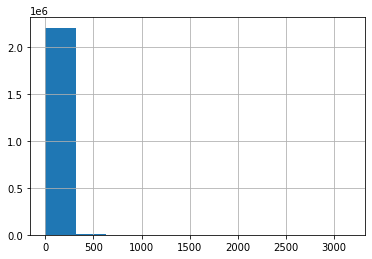

In [175]:
feat1_df["sales_volume_hl_agg"].hist()

In [ ]:
feat1_df = feat1_df.drop(["year_month_start_date"], axis=1)

In [177]:
os.makedirs(os.path.join(os.getcwd(), "feature_engineered_data"), exist_ok=True)
feat1_df.to_pickle(
    os.path.join(os.getcwd(), "feature_engineered_data", "sample_submission_test.pkl")
)